# Understanding the dataset


**Data Set Information:**

The training dataset consists of data corresponding to 50553 customers and the test dataset consists of 12661 customers.


**Features:**

• Target: Claim Status (Claim) 
• Name of agency (Agency) 
• Type of travel insurance agencies (Agency Type) 
• Distribution channel of travel insurance agencies (Distribution Channel) 
• Name of the travel insurance products (Product Name) 
• Duration of travel (Duration) • Destination of travel (Destination) 
• Amount of sales of travel insurance policies (Net Sales) 
• The commission received for travel insurance agency (Commission) 
• Gender of insured (Gender) 
• Age of insured (Age)

**Output variable (desired target):**  

|Feature|Feature_Type|Description|
|-----|-----|-----|
|Claim | binary| ('1','0')|

# Exploratory Data Analysis & Data Pre Processing

###  Importing necessary libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

### Loading Data Modelling Libraries

In [2]:
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier ,RandomForestClassifier ,GradientBoostingClassifier
from xgboost import XGBClassifier 
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.linear_model import Ridge,Lasso
from sklearn.metrics import roc_auc_score ,mean_squared_error,accuracy_score,classification_report,roc_curve,confusion_matrix,precision_score
import warnings
warnings.filterwarnings('ignore')
from scipy.stats.mstats import winsorize
from sklearn.feature_selection import RFE
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA 
from sklearn.model_selection import KFold
from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import SVR
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import SMOTE

### Load and Prepare dataset
- Load the dataframe using pandas. 
- Seperate the features and target.

In [3]:
# Load the dataframe
insure_df=pd.read_csv("./train.csv")

# Seperate the features and target
target = insure_df['Claim']
predictors = insure_df.drop(['Claim'],axis=1)
df_test=pd.read_csv("./test.csv")
predictors.head()

,ID,Agency,Agency Type,Distribution Channel,Product Name,Duration,Destination,Net Sales,Commision (in value),Gender,Age
0,3433,CWT,Travel Agency,Online,Rental Vehicle Excess Insurance,7,MALAYSIA,0.0,17.82,NaN,31
1,4339,EPX,Travel Agency,Online,Cancellation Plan,85,SINGAPORE,69.0,0.00,NaN,36
2,34590,CWT,Travel Agency,Online,Rental Vehicle Excess Insurance,11,MALAYSIA,19.8,11.88,NaN,75
3,55816,EPX,Travel Agency,Online,2 way Comprehensive Plan,16,INDONESIA,20.0,0.00,NaN,32
4,13816,EPX,Travel Agency,Online,Cancellation Plan,10,"KOREA, REPUBLIC OF",15.0,0.00,NaN,29


### Check Numeric and Categorical Features
- The given dataset contains both continuous and categorical features.
- Wrote two functions - one which return column names of only the continuous variables and the other which return all the categorical features in the dataset.

In [4]:
# Function to identify numeric features
def numeric_features(dataset):
    numeric_col = dataset.select_dtypes(include=['number']).columns
    return numeric_col

numeric_columns = numeric_features(predictors)
print("Numeric Features:")
print(numeric_columns)
print("===="*20)

# Function to identify categorical features
def categorical_features(dataset):
    categorical_col = dataset.select_dtypes(exclude=['number']).columns
    return categorical_col

categorical_columns = categorical_features(predictors)
print("Categorical Features:")
print(categorical_columns)

Numeric Features:
Index(['ID', 'Duration', 'Net Sales', 'Commision (in value)', 'Age'], dtype='object')
Categorical Features:
Index(['Agency', 'Agency Type', 'Distribution Channel', 'Product Name',
       'Destination', 'Gender'],
      dtype='object')


### Check Missing Data 
- Wrote a function that calculates the total missing values and the percentage of missing values in every feature of the dataset
- The above function returns a dataframe consisting of the feature names as index and two columns having the count and percentage of missing values in that feature.

In [5]:
# Function to identify the number of missing values in every feature of Train dataset
def missing_datas(dataset):
    total = dataset.isnull().sum().sort_values(ascending=False)
    percent = (dataset.isnull().sum()/dataset.isnull().count()).sort_values(ascending=False)
    missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
    return missing_data
    
missing_data = missing_datas(predictors)
print(missing_data)

                      Total   Percent
Gender                35953  0.711194
Age                       0  0.000000
Commision (in value)      0  0.000000
Net Sales                 0  0.000000
Destination               0  0.000000
Duration                  0  0.000000
Product Name              0  0.000000
Distribution Channel      0  0.000000
Agency Type               0  0.000000
Agency                    0  0.000000
ID                        0  0.000000


In [6]:
# Function to identify the number of missing values in every feature of Test dataset
missing_data = missing_datas(df_test)
print(missing_data)

                      Total   Percent
Gender                 9056  0.715267
Age                       0  0.000000
Commision (in value)      0  0.000000
Net Sales                 0  0.000000
Destination               0  0.000000
Duration                  0  0.000000
Product Name              0  0.000000
Distribution Channel      0  0.000000
Agency Type               0  0.000000
Agency                    0  0.000000
ID                        0  0.000000


### Dropping / Imputing Missing Values

Since more than 50% of the Gender data is missing in both train and test data, we will drop the feature instead of imputing it

In [7]:
predictors.drop(['Gender', 'ID'], axis=1, inplace= True)
df_test.drop(['ID','Gender'], axis=1, inplace= True)

In [8]:
predictors.head()

,Agency,Agency Type,Distribution Channel,Product Name,Duration,Destination,Net Sales,Commision (in value),Age
0,CWT,Travel Agency,Online,Rental Vehicle Excess Insurance,7,MALAYSIA,0.0,17.82,31
1,EPX,Travel Agency,Online,Cancellation Plan,85,SINGAPORE,69.0,0.00,36
2,CWT,Travel Agency,Online,Rental Vehicle Excess Insurance,11,MALAYSIA,19.8,11.88,75
3,EPX,Travel Agency,Online,2 way Comprehensive Plan,16,INDONESIA,20.0,0.00,32
4,EPX,Travel Agency,Online,Cancellation Plan,10,"KOREA, REPUBLIC OF",15.0,0.00,29


### Check for Class Imbalance
Check the class distribution of all the classes in the target. If an imbalance exists, we will deal with it by applying SMOTE in the later stages.

In [9]:
def class_imbalance(target):
    class_values = (target.value_counts()/target.value_counts().sum())*100
    return class_values

class_imbalance(target)

0    98.534212
1     1.465788
Name: Claim, dtype: float64

The distribution 99:1 is a clear indication of imbalance in the classes. 

### Univariate analysis of Categorical columns
- Wrote a function that plots the frequency of the values of all the categorical variables

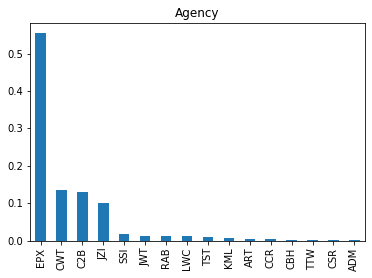

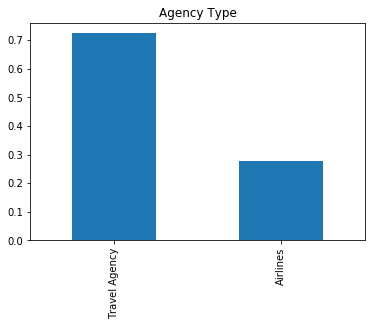

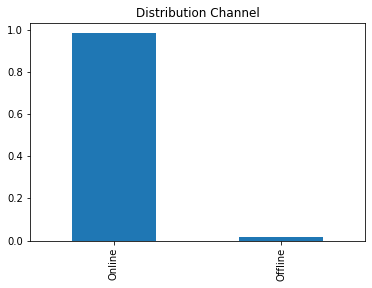

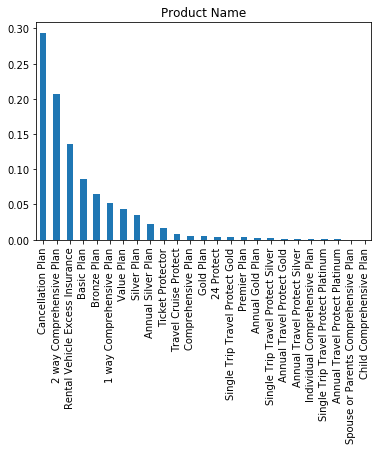

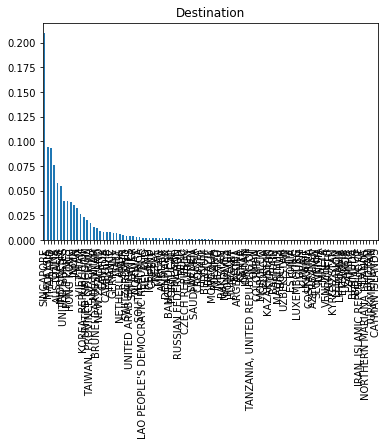

In [10]:
# Function to perform univariate analysis of categorical columns
def plot_categorical_columns(dataframe):
    categorical_columns = categorical_features(dataframe)
    dataframe = dataframe[categorical_columns]
    for i in dataframe:
        plt.title(i)
        dataframe[i].value_counts(normalize=True).plot(kind='bar')
        plt.show()

plot = plot_categorical_columns(predictors)

### Univariate analysis of Continuous columns
- Construct two functions, one that plots a histogram of all the continuous features and other that plots a boxplot of the same. Histograms are great for plotting the distribution of the data and boxplots are the best choice for visualizing outliers.

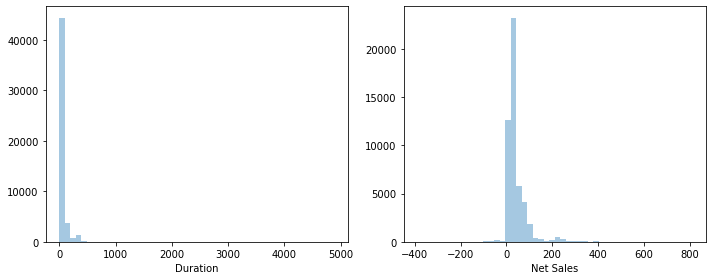

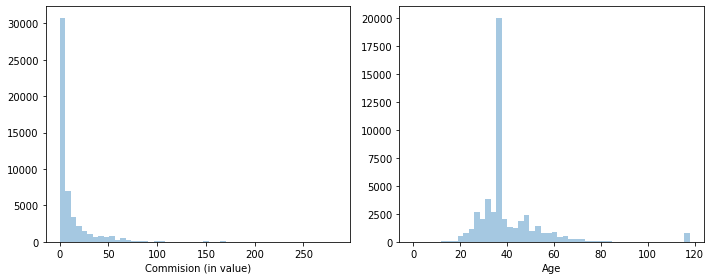

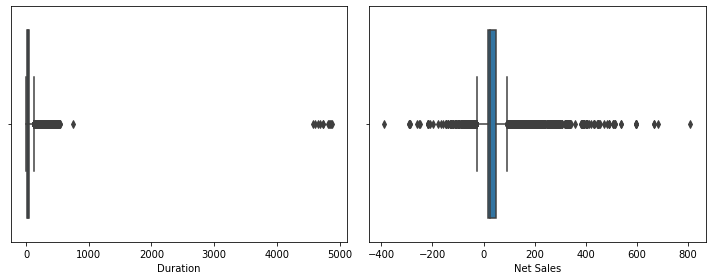

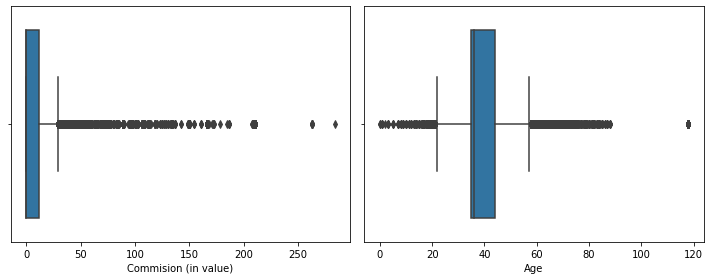

In [11]:
# Function to plot histograms of Continuous columns
def plot_continuous_columns(dataframe):
    numeric_columns = numeric_features(dataframe)
    dataframe = dataframe[numeric_columns]
    
    for i in range(0,len(numeric_columns),2):
        if len(numeric_columns) > i+1:
            plt.figure(figsize=(10,4))
            plt.subplot(121)
            sns.distplot(dataframe[numeric_columns[i]], kde=False)
            plt.subplot(122)            
            sns.distplot(dataframe[numeric_columns[i+1]], kde=False)
            plt.tight_layout()
            plt.show()

        else:
            sns.distplot(dataframe[numeric_columns[i]], kde=False)

# Function to plot boxplots of Continuous columns
def plot_box_plots(dataframe):
    numeric_columns = numeric_features(dataframe)
    dataframe = dataframe[numeric_columns]
    
    for i in range(0,len(numeric_columns),2):
        if len(numeric_columns) > i+1:
            plt.figure(figsize=(10,4))
            plt.subplot(121)
            sns.boxplot(dataframe[numeric_columns[i]])
            plt.subplot(122)            
            sns.boxplot(dataframe[numeric_columns[i+1]])
            plt.tight_layout()
            plt.show()

        else:
            sns.boxplot(dataframe[numeric_columns[i]])

plot_continuous_columns(predictors)            
plot_box_plots(predictors)

### Bivariate Analysis - Categorical Columns

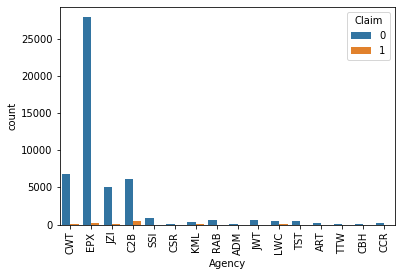

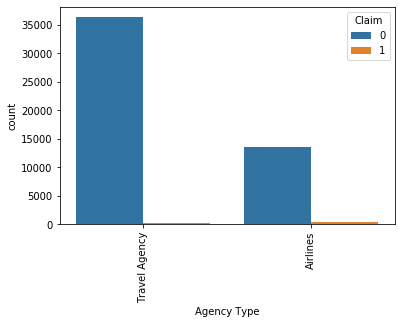

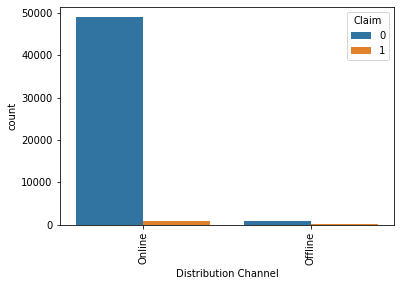

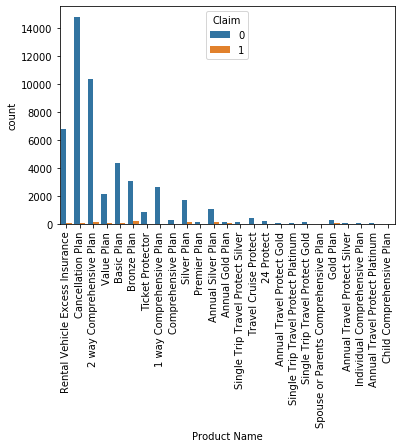

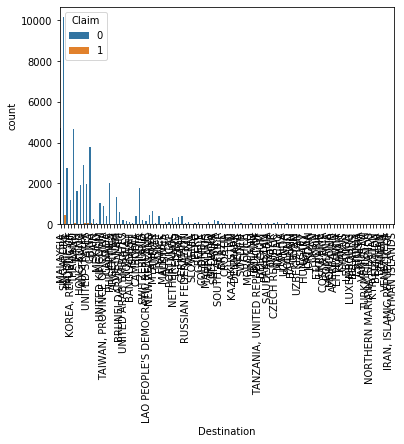

In [12]:
def bivariate_analysis_categorical(dataframe,target):
    cols = list(dataframe)
    for col in cols:
        if col in dataframe.select_dtypes(exclude=np.number).columns:
            sns.countplot(x=dataframe[col],hue=target,data=dataframe)
            plt.xticks(rotation='vertical')
            plt.show()

bivariate_analysis_categorical(predictors,target)

### Detect outliers in the continuous columns
- Wrote a function that will output the number of outliers in every numeric feature based on 1.5*IQR method

In [13]:
# Function to detect outliers in every feature
def detect_outliers(dataframe):
    cols = list(dataframe)
    
    for column in cols:
        if column in dataframe.select_dtypes(include=np.number).columns:
            q1 = dataframe[column].quantile(0.25)
            q3 = dataframe[column].quantile(0.75)
            iqr = q3 - q1
            fence_low = q1 - (1.5*iqr)
            fence_high = q3 + (1.5*iqr)

            print(column + ' ---------', dataframe.loc[(dataframe[column] < fence_low) | (dataframe[column] > fence_high)].shape[0])

detect_outliers(predictors)

Duration --------- 4465
Net Sales --------- 4444
Commision (in value) --------- 5629
Age --------- 4702


### Treat outliers in the continuous columns
- Outliers can be treated in a variety of ways. It depends on the skewness of the feature.
- Outliers in Age and Duration are replaced with Mean values

In [14]:
predictors.skew()

Duration                22.872743
Net Sales                3.328243
Commision (in value)     4.078189
Age                      2.978478
dtype: float64

In [15]:
#Replacing outliers from Age with Mean value
predictors['Age'] = predictors['Age'].replace(to_replace = 118, value = 88)

df_test['Age']=df_test['Age'].replace(to_replace=118,value=88)

In [16]:
#Replacing outliers from Duration with Mean value
predictors.Duration[predictors['Duration']>1000]=60
df_test.Duration[df_test['Duration'] > 1000]= 60

In [17]:
predictors.describe()

,Duration,Net Sales,Commision (in value),Age
count,50553.000000,50553.000000,50553.00000,50553.000000
mean,48.405930,40.800977,9.83809,39.539454
std,74.042783,48.899683,19.91004,11.768262
min,-2.000000,-389.000000,0.00000,0.000000
25%,9.000000,18.000000,0.00000,35.000000
50%,22.000000,26.500000,0.00000,36.000000
75%,53.000000,48.000000,11.55000,44.000000
max,740.000000,810.000000,283.50000,88.000000


In [18]:
df_test.describe()

,Duration,Net Sales,Commision (in value),Age
count,12661.000000,12661.000000,12661.000000,12661.000000
mean,47.796304,40.148315,9.716776,39.375563
std,72.948089,48.686831,19.401245,11.571166
min,-1.000000,-357.500000,0.000000,1.000000
25%,9.000000,18.000000,0.000000,35.000000
50%,22.000000,26.500000,0.000000,36.000000
75%,52.000000,47.000000,11.550000,43.000000
max,529.000000,586.000000,210.210000,88.000000


In [19]:
predictors.skew()

Duration                3.172837
Net Sales               3.328243
Commision (in value)    4.078189
Age                     1.706887
dtype: float64

### Find Correlation between Features

A correlation heatmap uses colored cells, typically in a monochromatic scale, to show a 2D correlation matrix (table) between two discrete dimensions or event types. The color value of the cells is proportional to the number of measurements that match the dimensional values.

- Wrote a function that will plot a heatmap using seaborn to depict the pearson correlation of all the numeric features.

Highly Correlated Variables


Series([], dtype: float64)

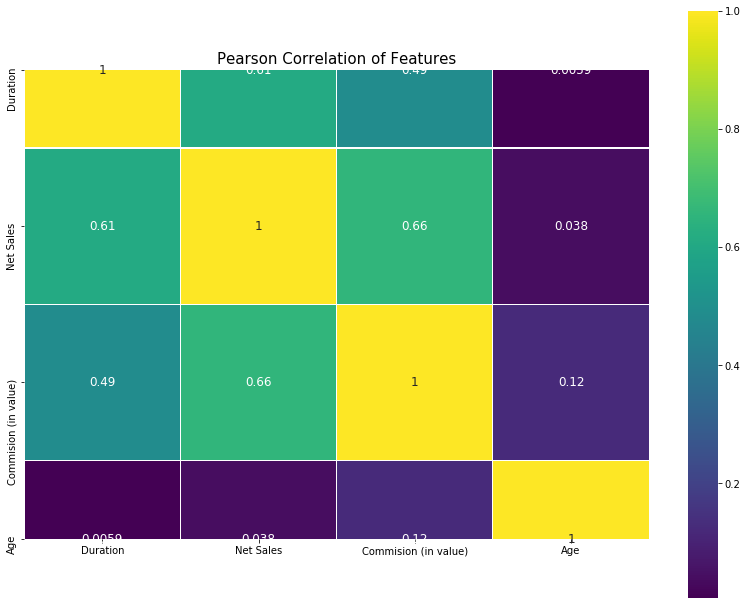

In [20]:
#correlation heatmap of dataset
def correlation_heatmap(df):
    _ , ax = plt.subplots(figsize =(14, 12))
    colormap = sns.diverging_palette(220, 10, as_cmap = True)
    
    _ = sns.heatmap(
        df.corr(), 
        cmap = 'viridis',
        square=True, 
        cbar_kws={'shrink':.9 }, 
        ax=ax,
        annot=True, 
        linewidths=0.1,vmax=1.0, linecolor='white',
        annot_kws={'fontsize':12 }
    )
    
    plt.title('Pearson Correlation of Features', y=1.05, size=15)
    
    correlation = df.corr().unstack().sort_values(kind='quicksort')
    print('Highly Correlated Variables')
    return correlation[((correlation>=0.75) | (correlation<=-0.75)) & (correlation!=1)]

correlation_heatmap(predictors)

In [21]:
numeric_col=predictors.select_dtypes(include=['number']).columns

### Label Encode Categorical variables

Since our machine learning algorithm can only read numerical values, it is essential to encode categorical features into numerical values.

- Wrote a function that will perform label encoding on all the categorical features and also the target (if it is categorical) in the  dataset.

In [22]:
from sklearn.preprocessing import RobustScaler, StandardScaler
scaler=RobustScaler()

for cols in predictors.select_dtypes(exclude='object'):
    predictors[cols]=scaler.fit_transform(predictors[cols].values.reshape(-1,1))
    df_test[cols]=scaler.transform(df_test[cols].values.reshape(-1,1))

In [23]:
df_test.head()

,Agency,Agency Type,Distribution Channel,Product Name,Duration,Destination,Net Sales,Commision (in value),Age
0,CWT,Travel Agency,Online,Rental Vehicle Excess Insurance,0.818182,ICELAND,0.766667,2.571429,1.222222
1,EPX,Travel Agency,Online,2 way Comprehensive Plan,-0.409091,SINGAPORE,-0.216667,0.000000,-1.333333
2,EPX,Travel Agency,Online,2 way Comprehensive Plan,1.045455,VIET NAM,-0.216667,0.000000,0.000000
3,EPX,Travel Agency,Online,2 way Comprehensive Plan,0.431818,CHINA,0.050000,0.000000,0.000000
4,EPX,Travel Agency,Online,Cancellation Plan,-0.136364,SINGAPORE,-0.516667,0.000000,0.000000


In [24]:
columnsToEncode = list(predictors.select_dtypes(include=['category','object']))
le = LabelEncoder()
for cols in columnsToEncode:
    predictors[cols]=le.fit_transform(predictors[cols])
    df_test[cols]=le.transform(df_test[cols])       

In [25]:
predictors.head()

,Agency,Agency Type,Distribution Channel,Product Name,Duration,Destination,Net Sales,Commision (in value),Age
0,6,1,1,16,-0.340909,56,-0.883333,1.542857,-0.555556
1,7,1,1,10,1.431818,79,1.416667,0.000000,0.000000
2,6,1,1,16,-0.250000,56,-0.223333,1.028571,4.333333
3,7,1,1,1,-0.136364,38,-0.216667,0.000000,-0.444444
4,7,1,1,10,-0.272727,47,-0.383333,0.000000,-0.777778


In [26]:
df_test.head()

,Agency,Agency Type,Distribution Channel,Product Name,Duration,Destination,Net Sales,Commision (in value),Age
0,6,1,1,16,0.818182,36,0.766667,2.571429,1.222222
1,7,1,1,1,-0.409091,79,-0.216667,0.000000,-1.333333
2,7,1,1,1,1.045455,100,-0.216667,0.000000,0.000000
3,7,1,1,1,0.431818,17,0.050000,0.000000,0.000000
4,7,1,1,10,-0.136364,79,-0.516667,0.000000,0.000000


# Baseline Model and Feature Engineering

In [27]:
# Split Train dataset into training and validation data
X_train,X_test,y_train,y_test = train_test_split(predictors, target, test_size=0.2, random_state=42)

In [28]:
model=LogisticRegression() 
model.fit(X_train,y_train)
y_pred=model.predict(X_test)
print(classification_report(y_test,y_pred))
print(accuracy_score(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.99      1.00      0.99      9962
           1       0.00      0.00      0.00       149

    accuracy                           0.98     10111
   macro avg       0.49      0.50      0.50     10111
weighted avg       0.97      0.98      0.98     10111

0.9848679655820394


In [29]:
# Applying SMOTE for dealing with class imbalance
smote = SMOTE(kind='regular')
X_sm, y_sm =  smote.fit_sample(predictors, target)

# Split Train dataset into training and testing data after applying SMOTE
X_train_s,X_test_s,y_train_s,y_test_s=train_test_split(X_sm,y_sm,test_size=0.2,random_state=42)

#### Baseline Logistic Model

In [30]:
model1=LogisticRegression() 
model1.fit(X_train_s,y_train_s)
y_pred=model1.predict(X_test_s)
print(classification_report(y_test_s,y_pred))
print(accuracy_score(y_test_s,y_pred))

              precision    recall  f1-score   support

           0       0.71      0.83      0.77     10043
           1       0.79      0.66      0.72      9882

    accuracy                           0.74     19925
   macro avg       0.75      0.74      0.74     19925
weighted avg       0.75      0.74      0.74     19925

0.7449435382685069


In [31]:
df_pred=model1.predict(df_test)

In [32]:
np.bincount(df_pred)

array([10454,  2207], dtype=int64)

#### Applying Other Models

In [33]:
def run_model(predictor_train,target_train,predictor_test,target_test, model):
    '''
    Performs model training and tests using ROC-AUC 
    returns AUC score
    '''
    #x_train,x_val,y_train,y_val = train_test_split(predictor_train,target_train,test_size=0.2,random_state=42)
    model.fit(predictor_train, target_train)
    y_p=model.predict(predictor_test)
    y_scores = model.predict(df_test)
    #y_lr=model.predict(df_test)
    print(np.bincount(y_scores))
    
    print(classification_report(target_test,y_p))
    print(confusion_matrix(target_test,y_p))

LR=LogisticRegression()
DT=DecisionTreeClassifier()
RFC=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=6, max_features=3, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=8, min_samples_split=10,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=2018,
                       verbose=0, warm_start=False)

models = [LR,DT,RFC]
for model in models:
    # run model
    
    print('Model'+str(model))
    auc = run_model(X_train_s,y_train_s,X_test_s,y_test_s ,model) # train and returns AUC test score
    
    print('===='*20)

ModelLogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)
[10454  2207]
              precision    recall  f1-score   support

           0       0.71      0.83      0.77     10043
           1       0.79      0.66      0.72      9882

    accuracy                           0.74     19925
   macro avg       0.75      0.74      0.74     19925
weighted avg       0.75      0.74      0.74     19925

[[8332 1711]
 [3371 6511]]
ModelDecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                   

In [34]:
RFC=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=6, max_features=3, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=8, min_samples_split=10,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=2018,
                       verbose=0, warm_start=False)

RFC.fit(X_train_s,y_train_s)
y_p=RFC.predict(X_test_s)
roc_auc_pred=roc_auc_score(y_test_s,y_p)
y_test_pred=RFC.predict(df_test)

print(classification_report(y_test_s,y_p))
print('ROC_AUC_Score:',roc_auc_pred)
print(np.bincount(y_test_pred))

              precision    recall  f1-score   support

           0       0.81      0.85      0.83     10043
           1       0.84      0.79      0.82      9882

    accuracy                           0.82     19925
   macro avg       0.82      0.82      0.82     19925
weighted avg       0.82      0.82      0.82     19925

ROC_AUC_Score: 0.8230515129811271
[10689  1972]


In [35]:
#test_df_chk=pd.DataFrame(y_test_pred)
#test_df_chk.to_csv('chk1.csv')

## Feature Selection

###  Using RFE for feature selection
Recursive Feature Elimination is used for selecting the best features.

- The function below takes the number of features as a parameter and uses RFE for each of the specific models - LogisticRegression,DecisionTreeClassifier,RandomForestClassifier and outputs the best features for each model.


In [36]:
def feature_selection(dataframe,target,number_of_features,model):
    X = dataframe
    y = target

    models = model()
    rfe = RFE(models,number_of_features)
    rfe = rfe.fit(X,y)
    print('Features  to be selected for {}'.format(str(models)))
    features = pd.Series(rfe.ranking_, index=X.columns)
    print(features[features.values==1].index.tolist())
    print('===='*30)

# Choosing the models
models = [LogisticRegression,DecisionTreeClassifier,RandomForestClassifier]

# Selecting 8 number of features
for i in models:
    feature_selection(X_train,y_train,7,i)

Features  to be selected for LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)
['Agency', 'Agency Type', 'Distribution Channel', 'Duration', 'Net Sales', 'Commision (in value)', 'Age']
Features  to be selected for DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')
['Agency', 'Product Name', 'Duration', 'Destination', 'Net Sales', 'Commision (in value)', 'Age']
Features

In [37]:
X_rfe=predictors.drop(['Agency Type','Distribution Channel'],1)

In [38]:
X_rfe.head()

,Agency,Product Name,Duration,Destination,Net Sales,Commision (in value),Age
0,6,16,-0.340909,56,-0.883333,1.542857,-0.555556
1,7,10,1.431818,79,1.416667,0.000000,0.000000
2,6,16,-0.250000,56,-0.223333,1.028571,4.333333
3,7,1,-0.136364,38,-0.216667,0.000000,-0.444444
4,7,10,-0.272727,47,-0.383333,0.000000,-0.777778


In [39]:
sm=SMOTE()
X_rfe_s,y_s=sm.fit_sample(X_rfe,target)

In [40]:
X_train_rs,X_test_rs,y_train_rs,y_test_rs=train_test_split(X_rfe_s,y_s,random_state=6,test_size=0.2)

In [41]:
df_test_rfe=df_test.drop(['Agency Type','Distribution Channel'],1)

In [42]:
RFC=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=6, max_features=3, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=8, min_samples_split=10,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=2018,
                       verbose=0, warm_start=False)

RFC.fit(X_train_rs,y_train_rs)
y_p_rs=RFC.predict(X_test_rs)
roc_auc_pred=roc_auc_score(y_test_rs,y_p_rs)
y_test_pred=RFC.predict(df_test_rfe)

print(classification_report(y_test_rs,y_p_rs))
print('ROC_AUC_Score:',roc_auc_pred)
print(np.bincount(y_test_pred))

              precision    recall  f1-score   support

           0       0.80      0.84      0.82      9959
           1       0.83      0.79      0.81      9966

    accuracy                           0.82     19925
   macro avg       0.82      0.82      0.82     19925
weighted avg       0.82      0.82      0.82     19925

ROC_AUC_Score: 0.8172228543208169
[10508  2153]


In [43]:
#from sklearn.ensemble import RandomForestClassifier
#from sklearn.model_selection import GridSearchCV
#from sklearn.metrics import make_scorer
#from sklearn.model_selection import StratifiedKFold

#cv = StratifiedKFold(n_splits = 5, shuffle=True, random_state = 42)

#rdf = RandomForestClassifier(random_state = 42) 
#scoring = {'precision_score': make_scorer(precision_score),
#            'Recall': make_scorer(recall_score),
#           'f1_score': make_scorer(f1_score)
#           }

#params = {'max_depth': [6, 15, 20,50,100], 
#              'min_samples_split': [10, 15,50,100],
#              'min_samples_leaf' : [8, 12,50,100],
#               'n_estimators' : [100, 200, 300],
#               'max_features': [3,6,9]
#              }

#grid_clf = GridSearchCV(estimator = rdf, param_grid = params, cv = cv, n_jobs=-1, verbose=4)
#grid_clf.fit(X,y)

In [44]:
# print(grid_clf.best_estimator_)
# print(grid_clf.best_params_)

In [45]:
# Output: {'max_depth': 6, 'max_features': 3, 'min_samples_leaf': 8, 'min_samples_split': 10, 'n_estimators': 100}


### Grid Search using Logistic Regression

On Validation Data
ROC_AUC_SCORE is  0.7423234594022746
              precision    recall  f1-score   support

           0       0.71      0.82      0.76      7960
           1       0.79      0.66      0.72      7980

    accuracy                           0.74     15940
   macro avg       0.75      0.74      0.74     15940
weighted avg       0.75      0.74      0.74     15940



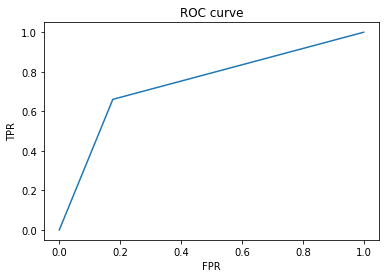

LogisticRegression(C=1389495.494373136, class_weight=None, dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)
{'C': 1389495.494373136}


In [46]:
def grid_search_log_reg(dataframe,target):
    X = dataframe
    y = target
    
    smote = SMOTE(kind='regular')
    X_sm, y_sm =  smote.fit_sample(X, y)
    x_train,x_val,y_train,y_val = train_test_split(X_sm, y_sm, test_size=0.2, random_state=42)
    
    log_reg = LogisticRegression()
    
    param_grid = { 
        'C' : np.logspace(-5, 8, 15)
    }
    grid_search = GridSearchCV(log_reg, param_grid=param_grid)
    
    grid_search.fit(x_train, y_train)
    y_pred = grid_search.predict(x_val)
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_val, y_pred)
    print('On Validation Data')
    print('ROC_AUC_SCORE is ',roc_auc_score(y_val, y_pred))
    print(classification_report(y_val, y_pred))
    plt.clf()
    plt.plot(false_positive_rate, true_positive_rate)
    plt.xlabel('FPR')
    plt.ylabel('TPR')
    plt.title('ROC curve')
    plt.show()
    
    print(grid_search.best_estimator_)
    print(grid_search.best_params_)

grid_search_log_reg(X_train,y_train)

In [47]:
X_rfe.head()

,Agency,Product Name,Duration,Destination,Net Sales,Commision (in value),Age
0,6,16,-0.340909,56,-0.883333,1.542857,-0.555556
1,7,10,1.431818,79,1.416667,0.000000,0.000000
2,6,16,-0.250000,56,-0.223333,1.028571,4.333333
3,7,1,-0.136364,38,-0.216667,0.000000,-0.444444
4,7,10,-0.272727,47,-0.383333,0.000000,-0.777778


### Applying XGBoost model

In [48]:
X_rf=predictors.drop(['Agency Type'],1)
test_rf=df_test.drop(['Agency Type'],1)

On Validation Data
Accuracy is  0.7364617314930991
              precision    recall  f1-score   support

           0       0.93      0.51      0.66     10043
           1       0.66      0.96      0.78      9882

    accuracy                           0.74     19925
   macro avg       0.80      0.74      0.72     19925
weighted avg       0.80      0.74      0.72     19925

ROC_AUC_SCORE is  0.7382675261403288
[[5170 4873]
 [ 378 9504]]
True Negatives:  5170
False Positives:  4873
False Negatives:  378
True Positives:  9504


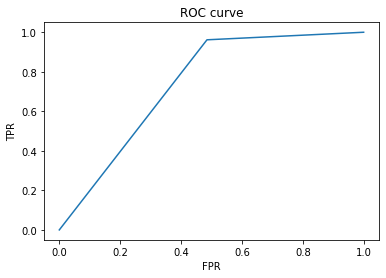

[6414 6247]


In [49]:
def xgboost(dataframe,target,test):
    X = dataframe
    y = target
    
    X=X.rename(columns={'Agency': 'f0','Distribution Channel':'f1','Product Name':'f2','Duration':'f3','Destination':'f4', 'Net Sales':'f5', 'Commision (in value)':'f6','Age':'f7'})
    test=test.rename(columns={'Agency': 'f0','Distribution Channel':'f1','Product Name':'f2','Duration':'f3','Destination':'f4', 'Net Sales':'f5', 'Commision (in value)':'f6','Age':'f7'})
    
    smote = SMOTE(kind='regular')
    X_sm, y_sm =  smote.fit_sample(X, y)
    
    x_train,x_val,y_train,y_val = train_test_split(X_sm, y_sm, test_size=0.2, random_state=42)
    
    model = XGBClassifier(learning_rate =0.1,n_estimators=30,max_depth=3,min_child_weight=3,subsample=0.8,colsample_bytree=0.8,nthread=5,scale_pos_weight=3,seed=27)
    
    model.fit(x_train, y_train)
    
    y_pred=model.predict(x_val)
    
    print('On Validation Data')
    print('Accuracy is ',model.score(x_val, y_val))
    print(classification_report(y_val, y_pred))
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_val, y_pred)
    #     print(auc(false_positive_rate, true_positive_rate))
    
    print('ROC_AUC_SCORE is ', roc_auc_score(y_val, y_pred))
    plt.clf()
    plt.plot(false_positive_rate, true_positive_rate)
    print(confusion_matrix(y_val, y_pred))
    tn, fp, fn, tp = confusion_matrix(y_val, y_pred).ravel()
    print("True Negatives: ",tn)
    print("False Positives: ",fp)
    print("False Negatives: ",fn)
    print("True Positives: ",tp)
    plt.xlabel('FPR')
    plt.ylabel('TPR')
    plt.title('ROC curve')
    plt.show()
    
    test_pred_chk=model.predict(test)
    print(np.bincount(test_pred_chk))

    test_pred_df=pd.DataFrame(test_pred_chk)
    test_pred_df.to_csv('Chk7.csv')


xgboost(X_rf,target,test_rf)

In [50]:
predictors.head()

,Agency,Agency Type,Distribution Channel,Product Name,Duration,Destination,Net Sales,Commision (in value),Age
0,6,1,1,16,-0.340909,56,-0.883333,1.542857,-0.555556
1,7,1,1,10,1.431818,79,1.416667,0.000000,0.000000
2,6,1,1,16,-0.250000,56,-0.223333,1.028571,4.333333
3,7,1,1,1,-0.136364,38,-0.216667,0.000000,-0.444444
4,7,1,1,10,-0.272727,47,-0.383333,0.000000,-0.777778


# Ensembling

On Validation Data
AUC_ROC_SCORE is  0.8264062940608168
              precision    recall  f1-score   support

           0       0.75      0.98      0.85     10043
           1       0.97      0.67      0.79      9882

    accuracy                           0.83     19925
   macro avg       0.86      0.83      0.82     19925
weighted avg       0.86      0.83      0.82     19925

[[9850  193]
 [3241 6641]]


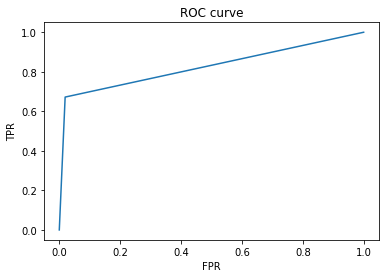

[12403   258]


In [51]:
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import VotingClassifier

def ensemble_func2(dataframe,target,test):
    X = dataframe
    y = target
    
    smote = SMOTE(kind='regular')
    X_sm, y_sm =  smote.fit_sample(X, y)
    x_train,x_val,y_train,y_val = train_test_split(X_sm, y_sm, test_size=0.2, random_state=42)

    model1 = RandomForestClassifier()
    
    model2 = LogisticRegression()
    
    model = VotingClassifier(estimators=[('rf', model1), ('lr', model2)], voting='hard')
    model.fit(x_train,y_train)
    y_pred = model.predict(x_val)
    model.score(x_val,y_val)

        
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_val, y_pred)
    print('On Validation Data')
    print('AUC_ROC_SCORE is ',roc_auc_score(y_val, y_pred))
    
    print(classification_report(y_val, y_pred))
    print(confusion_matrix(y_val, y_pred))
    
    plt.clf()
    plt.plot(false_positive_rate, true_positive_rate)
    plt.xlabel('FPR')
    plt.ylabel('TPR')
    plt.title('ROC curve')
    plt.show()
    
    y_pred_test = model.predict(test)
    print(np.bincount(y_pred_test))

    #test_pred_df=pd.DataFrame(y_pred_test)
    #test_pred_df.to_csv('Chk5.csv')
    
ensemble_func2(X_rfe,target,df_test_rfe)